In [172]:
import importlib
import src.utils
import src.models

importlib.reload(src.utils)
importlib.reload(src.models)

from src.utils import load_data, load_model, DatasetMetadata, clean_instance
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy as sp
# str to sympy
from sympy.parsing.sympy_parser import parse_expr

from torch.utils.data import DataLoader
from src.models import LogisticModel
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = device if not torch.backends.mps.is_available() else torch.device("mps")


In [173]:
class State:
    def __init__(self, model, metadata, max_epochs, dx_scaled, mean_scaled, upd_weights):
        self.model: LogisticModel = model
        self.metadata: DatasetMetadata = metadata
        self.dx_scaled: torch.Tensor = dx_scaled
        self.mean_scaled: torch.Tensor = mean_scaled
        self.epochs: int = 0
        self.max_epochs: int = max_epochs
        self.upd_weights: torch.Tensor = upd_weights # columns to be updated
        self.apply_reg = False # When to apply integer regularization
        self.reg_vars = False # When to apply nº variables regularization


In [174]:
# def distance(original, new, weights, state: State = None, with_reg=False):
#     if with_reg:
#         # Calculate the distance with regularization
#         return ((original - new) ** 2  * weights + np.min((np.log((state.epochs + 1) ** (1/1)) ** 2, 2)) * 
#                 (1 - torch.cos(2 * torch.pi * (new * state.dx_scaled + state.mean_scaled) * state.metadata.int_cols)) ** 3)[weights != 0].sum()
#     else:
#         return ((original - new) ** 2 * weights).sum()
def distance(original, new, weights, state: State = None, with_reg=False):
    cost = (original - new) ** 2 * weights
    
    if with_reg:
        # Calculate the distance with regularization
        # return ((original - new) ** 2 * weights +
        #         2 - (1 + torch.cos(2 * torch.pi * (new * state.dx_scaled + state.mean_scaled) * state.metadata.int_cols)) ** 3)[weights != 0].sum()
        return (cost + 
                (torch.tan(torch.pi * (new * state.dx_scaled + state.mean_scaled) * state.metadata.int_cols)) ** 2)[weights != 0].sum()
    else:
        return (cost).sum()

In [175]:
def distance(original: torch.Tensor, new: torch.Tensor, weights: torch.Tensor, state: State = None):
    cost = (original - new) ** 2 * weights
    if torch.any(original != new) and state.reg_vars:
        epsilon = 30
        
        cost += sum([10 * (1 - torch.exp(-((o - n) ** 2) * epsilon)) for o, n in zip(original, new)])



        # n = original.numel()
        # suma = (original - new).abs().sum() + n * epsilon
        # cost -= sum([((o - n).abs() + epsilon)/ suma * torch.log(((o - n).abs() + epsilon)/ suma) for o, n in zip(original, new)])
    
    if state.apply_reg:
        # Calculate the distance with regularization
        # return ((original - new) ** 2 * weights +
        #         2 - (1 + torch.cos(2 * torch.pi * (new * state.dx_scaled + state.mean_scaled) * state.metadata.int_cols)) ** 3)[weights != 0].sum()
        return (cost + 
                (torch.tan(torch.pi * (new * state.dx_scaled + state.mean_scaled) * state.metadata.int_cols)) ** 2)[weights != 0].sum()
    else:
        return (cost).sum()

In [413]:
def unscale_instance(instance: torch.Tensor, metadata: DatasetMetadata, inplace: bool = False):
    cols_to_unscale = instance[metadata.cols_for_scaler].reshape(1, -1)
    mean = torch.tensor(metadata.scaler.mean_)
    std = torch.tensor(metadata.scaler.scale_)
    unscaled_cols = cols_to_unscale * std + mean
    if inplace:
        instance[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance
    else:
        instance_clone = instance.clone()
        instance_clone[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance_clone
    
def scale_instance(instance: torch.Tensor, metadata: DatasetMetadata, inplace: bool = False):
    cols_to_scale = instance[metadata.cols_for_scaler].reshape(1, -1)
    mean = torch.tensor(metadata.scaler.mean_)
    std = torch.tensor(metadata.scaler.scale_)
    scaled_cols = (cols_to_scale - mean) / std
    if inplace:
        instance[metadata.cols_for_scaler] = torch.tensor(scaled_cols, dtype=torch.float32).to(device)
        return instance
    else:
        instance_clone = instance.clone()
        instance_clone[metadata.cols_for_scaler] = torch.tensor(scaled_cols, dtype=torch.float32).to(device)
        return instance_clone
    
def round_instance(instance: torch.Tensor, metadata: DatasetMetadata):
    unscaled_person = unscale_instance(instance, metadata)
    unscaled_person[metadata.int_cols == 1] = torch.round(unscaled_person[metadata.int_cols == 1])
    person_new = scale_instance(unscaled_person, metadata)
    return person_new


def unscale_batch(batch: torch.Tensor, metadata: DatasetMetadata, inplace: bool = False):
    cols_to_unscale = torch.tensor(batch[:, metadata.cols_for_scaler], dtype=torch.float32)
    mean = torch.tensor(metadata.scaler.mean_, dtype=torch.float32)
    std = torch.tensor(metadata.scaler.scale_, dtype=torch.float32)
    unscaled_cols = cols_to_unscale * std + mean
    if inplace:
        batch[:, metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return batch
    else:
        batch_clone = batch.clone()
        batch_clone[:, metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return batch_clone
    
def scale_batch(batch: torch.Tensor, metadata: DatasetMetadata, inplace: bool = False):
    cols_to_scale = torch.tensor(batch[:, metadata.cols_for_scaler], dtype=torch.float32)
    mean = torch.tensor(metadata.scaler.mean_, dtype=torch.float32)
    std = torch.tensor(metadata.scaler.scale_, dtype=torch.float32)
    scaled_cols = (cols_to_scale - mean) / std
    if inplace:
        batch[:, metadata.cols_for_scaler] = torch.tensor(scaled_cols, dtype=torch.float32).to(device)
        return batch
    else:
        batch_clone = batch.clone()
        batch_clone[:, metadata.cols_for_scaler] = torch.tensor(scaled_cols, dtype=torch.float32).to(device)
        return batch_clone
    
def round_batch(batch: torch.Tensor, metadata: DatasetMetadata):
    unscaled_person = unscale_batch(batch, metadata)
    unscaled_person[metadata.int_cols == 1] = torch.round(unscaled_person[metadata.int_cols == 1])
    person_new = scale_batch(unscaled_person, metadata)
    return person_new

In [177]:
filename = 'data/Loan_default.csv'
model_name = "model_small"
model_dict = "models/"+model_name+".pth"

In [178]:
# load the model
test_data: DataLoader
_, _, test_data, _, metadata = load_data(filename, batch_size=1024)

inputs = next(iter(test_data))[0].to(torch.float32).to(device)

# define model
model = load_model(model_name).to(torch.float32).to(device)

torch.save(model.state_dict(), model_dict)


## Extract model equation

In [179]:
# import sympy as sp
# import torch

# def extract_symbolic_equation(model: torch.nn.Module, instance: torch.Tensor):
#     """
#     Extracts a symbolic equation from a trained PyTorch model.
#     Assumes a feedforward structure with linear layers and activations.
#     """
#     # Define symbolic variables for input features
#     x2, x3 = sp.symbols('x2 x3')  # Inputs
#     # constants = sp.symbols(f'c1:{model.input_dim + 1}')  # Constants for other features
    
#     # Build input vector with constants
#     x = [instance[i].item() if i not in [1, 2] else (x2 if i == 1 else x3) for i in range(model.input_dim)]
    
#     # Convert to a sympy matrix
#     X = sp.Matrix(x)
#     activations = []

#     # Iterate over layers
#     for layer in model.layers:
#         if isinstance(layer, torch.nn.Linear):
#             W = sp.Matrix(layer.weight.detach().numpy())  # Extract weight matrix
#             b = sp.Matrix(layer.bias.detach().numpy())    # Extract bias
#             X = W * X + b  # Apply linear transformation
#         elif isinstance(layer, torch.nn.ReLU):
#             activations.append(X)
#             X = X.applyfunc(lambda val: sp.Max(0, val))  # ReLU activation
#         elif isinstance(layer, torch.nn.Sigmoid):
#             activations.append(X)
#             X = X.applyfunc(lambda val: 1 / (1 + sp.exp(-val)))  # Sigmoid activation
#         # X.subs({sp.symbols(f'c{i+1}'): val for i, val in enumerate(inputs[0]) if i != 1 and i != 2})
#         print("Done: ", layer)
#         # print(X)


#     # Apply softmax at the end
#     denominator = sp.Add(*(sp.exp(e) for e in X))
#     softmax_expr = sp.Matrix([sp.exp(e) / denominator for e in X])

#     return softmax_expr, activations # .simplify()

# # Example usage
# model_sym = LogisticModel(inputs.shape[1], hidden_sizes=[16, 8])
# model_sym.load_state_dict(torch.load(model_dict))  # Load trained weights
# symbolic_eq, activations = extract_symbolic_equation(model_sym, inputs[0])
# model_eq = symbolic_eq[0]
# print(symbolic_eq)


In [180]:
# # with open('small.txt', 'w') as f:
# #     f.write(str(symbolic_eq))
# with open('small.txt', 'r') as f:
#     symbolic_eq1 = f.read()
#     symbolic_eq1 = parse_expr(symbolic_eq1)

## Training

In [181]:

person: torch.Tensor = inputs[0].to(torch.float32).to(device)
outputs = model(inputs).argmax(dim=1)
inputs_useful = inputs[outputs == 1]
# metadata.cols_for_mask = [False] * len(metadata.cols_for_mask)
# metadata.cols_for_mask[1] = True
# metadata.cols_for_mask[2] = True
# metadata.cols_for_mask[3] = True
# metadata.cols_for_mask[4] = True
# metadata.cols_for_mask[5] = True
# metadata.cols_for_mask[6] = True
# metadata.cols_for_mask[7] = True
# metadata.cols_for_mask[8] = True

weights = torch.tensor(metadata.cols_for_mask, dtype=torch.int).to(device)


In [182]:
person = inputs_useful[0].to(torch.float32).to(device)
# weights = torch.tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int).to(device)

In [183]:
# threshold = 0.5 + 1e-5



# def newton_op(model, person, weights, delta_threshold=0.1, reg=False, print_=False):
#     output = model(person.unsqueeze(0))

#     l = torch.nn.Parameter(torch.rand(1)[0].to(device))

#     # If the model predicts the person is likely to default:
#     if torch.argmax(output, dim=1).item() == 1:
#         # print("This person is likely to default")
        
        
#         person_new = person.clone().detach().to(device)
#         person_new.requires_grad = True

#         lr = 1

#         thres_term = 1
#         delta = torch.tensor([1, 1, 1], dtype=torch.float32).to(device)

#         # unscaled_person = unscale_instance(person, metadata)
#         # dx_scaled = scale_instance(unscaled_person + weights, metadata) - person
#         mean_scaled = torch.zeros_like(person_new, dtype=torch.float32).to(device)
#         mean_scaled[metadata.cols_for_scaler == 1] = torch.tensor(metadata.scaler.mean_).to(torch.float)
#         dx_scaled = torch.zeros_like(person_new, dtype=torch.float32).to(device)
#         dx_scaled[metadata.cols_for_scaler == 1] = torch.tensor(metadata.scaler.scale_).to(torch.float)
        
        

#         state = State(model, metadata, max_epochs=10, dx_scaled=dx_scaled, mean_scaled=mean_scaled)
#         apply_reg = False
#         first_time = True
#         while (abs(thres_term) > 1e-10 or torch.linalg.norm(delta) > 1e-5 * torch.linalg.norm(torch.cat((person_new, l.unsqueeze(0))))) and state.epochs < state.max_epochs:
            
#             if (abs(thres_term) < 0.1 and reg and first_time):
#                 apply_reg = True
#                 state.epochs = 0
#                 first_time = False

#             if state.epochs == 3:
#                 print()
#             def fpl_func(x, l):
#                 # cost_func = torch.autograd.grad(distance(person, x, weights, epochs, metadata.int_cols, cos_factor, reg), x, create_graph=True, allow_unused=True)[0][weights == 1]
#                 cost_func = torch.autograd.grad(distance(person, x, weights, state, apply_reg), x, create_graph=True, allow_unused=True)[0][weights == 1]
#                 restriction = torch.autograd.grad(model(x.unsqueeze(0))[0][0], x, create_graph=True, allow_unused=True)[0][weights == 1]
#                 l_derivative = (threshold - model(x.unsqueeze(0))[0][0]).unsqueeze(0)
#                 return torch.cat((cost_func - l * restriction, l_derivative))
            
#             fpl = fpl_func(person_new, l)
#             jac_tuple = torch.autograd.functional.jacobian(fpl_func, (person_new, l))

#             if torch.linalg.norm(jac_tuple[1], ord=float('inf')) < delta_threshold:
#                 # delta = torch.cat((torch.linalg.inv(jac_tuple[0][:-1, weights == 1]) @ fpl[:-1], torch.tensor([0])), dim=0)
#                 # if torch.linalg.norm(delta) < 10:
#                 delta = torch.cat((jac_tuple[0][-1, weights == 1]/torch.linalg.norm(jac_tuple[1]), torch.tensor([0])), dim=0)
#             else:
#                 jac = torch.cat((jac_tuple[0][:, weights == 1], jac_tuple[1].unsqueeze(-1)), dim=1)
#                 delta = (torch.linalg.inv(jac)) @ fpl

#             with torch.no_grad():
#                 person_new[weights == 1] -= delta[:-1] * lr
#                 l -= delta[-1] * lr

            
#             output_new = model(person_new.unsqueeze(0))

#             thres_term = (threshold - model(person_new.unsqueeze(0))[0][0]).unsqueeze(0).item()
#             state.epochs += 1

#             if print_:
#                 print("Epoch:", state.epochs)
#                 print("dist:", distance(person, person_new, weights, state, apply_reg).item(), ", threshold:", thres_term)
#                 print('Changes:', " delta1:", delta[0].item(), " delta2:", delta[1].item(), " delta_l:", delta[-1].item())

#         if print_:
#             print("Original output:", model(person.unsqueeze(0)))
#             print("New output:", output_new)
#             print("Original input unscaled:", unscale_instance(person, metadata))
#             print("New input unscaled:", unscale_instance(person_new, metadata))
#             print("Regularization strength:", l.item())
#             print("Epochs:", state.epochs)
#     return person_new, state # thres_term < 1e-5


In [184]:
threshold = 0.5 + 1e-5

def distance(original: torch.Tensor, new: torch.Tensor, weights: torch.Tensor, state: State = None):
    cost = (original - new) ** 2 * weights
    if torch.any(original != new) and state.reg_vars:
        epsilon = 30
        
        cost += sum([10 * (1 - torch.exp(-((o - n) ** 2) * epsilon)) for o, n in zip(original, new)])



        # n = original.numel()
        # suma = (original - new).abs().sum() + n * epsilon
        # cost -= sum([((o - n).abs() + epsilon)/ suma * torch.log(((o - n).abs() + epsilon)/ suma) for o, n in zip(original, new)])
    
    if state.apply_reg:
        # Calculate the distance with regularization
        # return ((original - new) ** 2 * weights +
        #         2 - (1 + torch.cos(2 * torch.pi * (new * state.dx_scaled + state.mean_scaled) * state.metadata.int_cols)) ** 3)[weights != 0].sum()
        return (cost + 
                (torch.tan(torch.pi * (new * state.dx_scaled + state.mean_scaled) * state.metadata.int_cols)) ** 2)[weights != 0].sum()
    else:
        return (cost).sum()

def newton_op(
        model: LogisticModel, 
        person: torch.Tensor, 
        weights: torch.Tensor, 
        delta_threshold: float = 0.1, 
        reg_int: bool = False, 
        reg_vars: bool = False, 
        print_:bool = False
    ):
    torch.manual_seed(0)
    output = model(person.unsqueeze(0))

    l = torch.nn.Parameter(torch.rand(1)[0].to(device))
    person_new = person.clone().detach().to(device)
    
    state = 0
    p_interest = 0

    if torch.argmax(output, dim=1).item() == 1:
        
        person_new.requires_grad = True

        lr = 1

        thres_term = 1
        delta = torch.tensor([1, 1, 1], dtype=torch.float32).to(device)

        mean_scaled = torch.zeros_like(person_new, dtype=torch.float32).to(device)
        mean_scaled[metadata.cols_for_scaler == 1] = torch.tensor(metadata.scaler.mean_).to(torch.float)
        dx_scaled = torch.zeros_like(person_new, dtype=torch.float32).to(device)
        dx_scaled[metadata.cols_for_scaler == 1] = torch.tensor(metadata.scaler.scale_).to(torch.float)
        
        state = State(model, metadata, max_epochs=100, dx_scaled=dx_scaled, mean_scaled=mean_scaled, upd_weights=weights)
        state.reg_vars = reg_vars
        state.apply_reg = False
        first_time = True
        continue_condition = True
        
        while continue_condition and state.epochs < state.max_epochs:
            
            if (abs(thres_term) < 0.1 and reg_int and first_time):
                state.apply_reg = True
                state.epochs = 0
                first_time = False

            def fpl_func(x: torch.Tensor, l: torch.Tensor):
                out = model(x.unsqueeze(0))[0][0]
                cost_func = torch.autograd.grad(distance(person, x, weights, state), x, create_graph=True, allow_unused=True)[0][state.upd_weights != 0]
                restriction = torch.autograd.grad(out, x, create_graph=True, allow_unused=True)[0][state.upd_weights != 0]
                l_derivative = (threshold - out).unsqueeze(0)
                return torch.cat((cost_func - l * restriction, l_derivative))
            
            fpl = fpl_func(person_new, l)
            jac_tuple = torch.autograd.functional.jacobian(fpl_func, (person_new, l))

            if torch.linalg.norm(jac_tuple[1], ord=float('inf')) < delta_threshold:
                delta = torch.cat((jac_tuple[0][-1, state.upd_weights != 0]/torch.linalg.norm(jac_tuple[1]), torch.tensor([0])), dim=0)
            else:
                jac = torch.cat((jac_tuple[0][:, state.upd_weights != 0], jac_tuple[1].unsqueeze(-1)), dim=1)
                delta = torch.linalg.inv(jac) @ fpl

            with torch.no_grad():
                person_new[state.upd_weights != 0] -= delta[:-1] * lr
                l -= delta[-1] * lr

            
            output_new = model(person_new.unsqueeze(0))

            thres_term = (threshold - output_new[0][0]).item()
            state.epochs += 1

            if print_:
                print("Epoch:", state.epochs)
                print("dist:", distance(person, person_new, weights, state).item(), ", threshold:", thres_term)
                print('Changes:', " delta1:", delta[0].item(), " delta2:", delta[1].item(), " delta_l:", delta[-1].item())
                
            continue_condition = (abs(thres_term) > 1e-15 or 
                                  torch.linalg.norm(delta) > 1e-7 * torch.linalg.norm(torch.cat((person_new, l.unsqueeze(0)))))
            if not continue_condition and state.apply_reg:
                state.upd_weights = weights & ~metadata.int_cols
                # print("Before rounding:", distance(person, person_new, weights, state, apply_reg).item())
                print([i.item() for i in unscale_instance(person_new, metadata)]) if print_ else None
                person_new = round_instance(person_new, metadata)
                p_interest = person_new.clone().detach()
                # state.apply_reg = False
                continue_condition = True
                # print("After rounding:", distance(person, person_new, weights, state, apply_reg).item(), (threshold - model(person_new.unsqueeze(0))[0][0]).item())


        if print_:
            print("Original output:", model(person.unsqueeze(0)))
            print("New output:", output_new)
            print("Original input unscaled:", unscale_instance(person, metadata))
            print("New input unscaled:", unscale_instance(person_new, metadata))
            print("Regularization strength:", l.item())
            print("Epochs:", state.epochs)
    return person_new, state, p_interest # thres_term < 1e-5


In [436]:
import src.counterfactual

importlib.reload(src.counterfactual)
from src.counterfactual import newton_op, minimality_check
# temp = [False] * len(metadata.cols_for_mask)
# temp[8] = True
# w = torch.tensor(temp, dtype=torch.int).to(device)
# p = torch.tensor([4.6000e+01, 8.4208e+04, 1.2919e+05, 4.5100e+02, 2.6000e+01, 3.0000e+00,
#         2.1170e+01, 2.4000e+01, 3.1000e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00,
#         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
#         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
#        dtype=torch.float32)
# p = scale_instance(p, metadata)
person = inputs_useful[2]
p_new, state_p = newton_op(model, person, metadata, weights, 0.1, reg_int=True, reg_vars=False, reg_clamp=True, print_=True)
# p_new, state_p, _ = newton_op(model, person, weights, 0.1, reg_int=False, reg_vars=False, print_=True)
print("Output inbounds:", (torch.clamp(p_new, metadata.min_values, metadata.max_values) == p_new).all())
sorted_points = minimality_check(person, p_new, weights, state_p, model, False, 1)
print((len(sorted_points)==0))
sorted_points

Epoch: 0
dist: 0.5981369018554688 , threshold: -0.12566101551055908
Changes:  delta1: -0.4104515612125397  delta_l: -4.803376197814941
Epoch: 1
dist: 0.2904902696609497 , threshold: -0.0024482011795043945
Changes:  delta1: 0.12479707598686218  delta_l: 3.4255824089050293
Epoch: 2
dist: 4.7801289558410645 , threshold: -5.900859832763672e-06
Changes:  delta1: -1.3894746189180296e-06  delta_l: -0.33244872093200684
Epoch: 3
dist: 2.517155408859253 , threshold: -1.1920928955078125e-06
Changes:  delta1: -2.4220074124059465e-07  delta_l: -0.021034862846136093
Epoch: 4
dist: 1.2929644584655762 , threshold: -1.1920928955078125e-07
Changes:  delta1: 1.252721393285583e-08  delta_l: -0.0006959894089959562
Epoch: 5
dist: 0.643860399723053 , threshold: -1.1920928955078125e-07
Changes:  delta1: 1.2527205939250052e-08  delta_l: -0.0007752248202450573
Epoch: 6
dist: 0.35453370213508606 , threshold: -1.1920928955078125e-07
Changes:  delta1: 1.2527198833822695e-08  delta_l: -0.0008932065684348345
Epoch: 

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_High School,...,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes,output,distance


In [435]:
# import src.counterfactual

# importlib.reload(src.counterfactual)
# from src.counterfactual import newton_op, distance, unscale_instance, scale_instance
# person = inputs_useful[0]
# person_new, state = newton_op(model, person, metadata, weights, 0.1, print_=True)
# person_new_clamp, state = newton_op(model, person, metadata, weights, 0.1, reg_clamp=True, print_=True)
# person_new_int, _ = newton_op(model, person, metadata, weights, reg_int=True, print_=True)
# person_new_vars, _ = newton_op(model, person, metadata, weights, reg_vars=True, print_=True)
# person_new_int_vars, _ = newton_op(model, person, metadata, weights, 0.1, reg_int=True, reg_vars=True, print_=True)

# names = ['person', 'person_new', 'person_new_clamp','person_new_int', 'person_new_vars', 'person_new_int_vars']
# ps = [eval(i) for i in names]
# outputs = [model(p.unsqueeze(0))[0][0].item() for p in ps]

# distances = [distance(person, p, weights, state=state).item() for p in ps]

# a = pd.DataFrame([unscale_instance(x, metadata).detach().cpu().numpy().reshape(-1) for x in ps], columns=metadata.columns)
# a['output'] = outputs
# a['distance'] = distances
# # set index
# a['names'] = names
# a = a.set_index('names')
# a.columns
# a

In [ ]:
import src.counterfactual

importlib.reload(src.counterfactual)
from src.counterfactual import newton_op, distance, minimality_check, integer_minimality_check
successes = 0
epochs = 0
bad_idxs = []
total = 0
for idx, p in enumerate(inputs_useful):
    # print("Person:", idx)
    p_new, ep = newton_op(model, p, metadata, weights, 0.1, reg_int=True, reg_vars=False, reg_clamp=True)
    # TODO: poner la minimalidad
    sorted_points = integer_minimality_check(p, p_new, weights, ep, model, noise=1, n_points=40_000)
    successes += len(sorted_points) == 0 # and (((state_p.metadata.max_values < p_new) | (state_p.metadata.min_values > p_new)).sum() == 0))
    # print("Person:", idx, "Rate of grad desc:",minimality_check(p, p_new, weights, ep, model))
    epochs += ep.epochs
    total += 1
    if not (len(sorted_points) == 0):
        bad_idxs.append(idx)
        print(idx, len(sorted_points))
print("Successes:", successes, "Total:", total)
print("Average epochs:", epochs / total)
print("Success rate:", successes / total)

Successes: 176 Total: 176
Average epochs: 67.26136363636364
Success rate: 1.0


### Prueba de todos los batches

In [189]:
# successes = 0
# bad_idxs = []
# total = 0
# for i, inputs in enumerate(test_data):
#     print(i, end='\r')
#     outputs = model(inputs[0]).argmax(dim=1)
#     inputs_useful = inputs[0][outputs == 1]
#     for idx, p in enumerate(inputs_useful):
#         _, ep = newton_op(model, p, weights, 0.1) #if idx not in [103, 105, 237, 406, 417, 450] else None
#         # print("Person:", idx, "Success:", not ep)
#         successes += ep
#         total += 1
#         # if not ep:
#         #     bad_idxs.append(idx)
#     print(successes/total)
# print("Successes:", successes, "Total:", total)
# print("Success rate:", successes / total)

# Properties checks

## Minimality Check

El problema de esto es que como hemos puesto un +1e-5 al threshold hay puntos que se acercan más al punto original que el que sacamos, pero es aposta

In [434]:
# # Check for minimality
# # Create points around the solution and check if they change the output with a smaller perturbation
# # TODO: funcion y a la comprobación de si está bien o no
# import src.counterfactual

# importlib.reload(src.counterfactual)
# from src.counterfactual import newton_op, distance

# person = inputs_useful[4]
# metadata.threshold = 0.5
# person_new, state = newton_op(model, person, metadata, weights, 0.1, False, False, print_=False)
# def minimality_check(person, person_new, weights, state, model):
#     noise = 0.00000001
#     n_points = 10000
#     points = torch.tensor(np.random.uniform(-noise, noise, (n_points, person_new.shape[0])) * weights.numpy() + person_new.detach().cpu().numpy().reshape(-1), dtype=torch.float32).to(device)
#     outputs = model(points)
#     # pandas dataset 
#     b = pd.DataFrame(points, columns=metadata.columns)
#     b['output'] = torch.argmax(outputs, dim=1).detach().cpu().numpy()
#     distances = torch.tensor([distance(person, p, weights, state) for p in points])
#     b['distance'] = distances.detach().cpu().numpy()
#     d = distance(person, person_new, weights, state).item()
#     sorted_b = b[b['distance'] <= d][b['output'] == 0].sort_values(by='distance')
#     return sorted_b

# minimality_check(person, person_new, weights, state, model)

### Minimality for the non int columns

In [433]:
# # Check for minimality
# # Create points around the solution and check if they change the output with a smaller perturbation
# # TODO: sumar ruido int para las columnas integer
# noise = 0.01
# n_points = 10000
# w = weights & ~metadata.int_cols
# points = torch.tensor(np.random.uniform(-noise, noise, (n_points, person_new_int.shape[0])) * w.numpy() + person_new_int.detach().cpu().numpy().reshape(-1), dtype=torch.float32).to(device)
# outputs = model(points)
# # pandas dataset
# b = pd.DataFrame(points, columns=metadata.columns)
# # add person_new_int_int to the dataframe
# b.loc[len(b)] = person_new_int.detach().cpu().numpy()
# b['output'] = [*torch.argmax(outputs, dim=1).detach().cpu().numpy(), 0]
# distances = torch.tensor([distance(person, p, w, state) for p in points])
# b['distance'] = [*distances.detach().cpu().numpy(), distance(person, person_new_int, w, state).item()]
# sorted_b = b[b['distance'] <= distance(person, person_new_int, w, state).item()][b['output'] == 0].sort_values(by='distance')
# sorted_b

## Plausability check

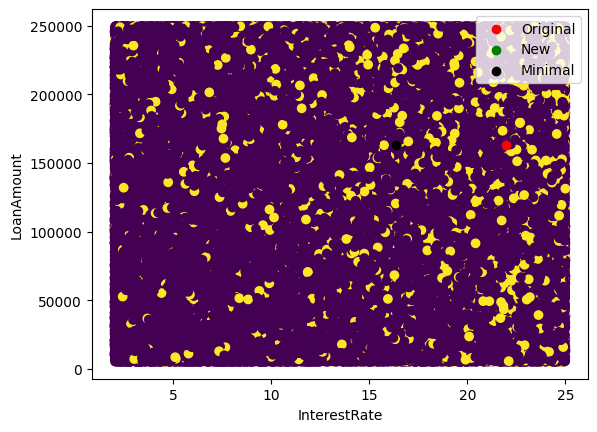

In [ ]:
# Check for plausability
data = pd.read_csv(filename)
cols = ["InterestRate", "LoanAmount"]
income = data[cols[0]]
loan = data[cols[1]]
default = data['Default']
plt.scatter(income, loan, c=default, cmap='viridis')
minimal_unscaled = unscale_instance(torch.tensor(sorted_b.iloc[0].to_numpy()[:-2]), metadata) if len(sorted_b) > 0 else None
plt.scatter(a[cols[0]][0], a[cols[1]][0], c='red', label='Original')
# find the index of columns
indexes = [list(metadata.columns).index(col) for col in cols]
plt.scatter(a[cols[0]][1], a[cols[1]][1], c='green', label='New')
plt.scatter(minimal_unscaled[indexes[0]], minimal_unscaled[indexes[1]], c='black', label='Minimal') if len(sorted_b) > 0 else None
plt.xlabel(cols[0])
plt.ylabel(cols[1])
plt.legend()
plt.show()